<a href="https://colab.research.google.com/github/karri-ten/VibeScope/blob/main/VibeScope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VibeScope _ Analysing online vibe through NLP

VibeScope analyzes Twitter conversations in real time, using NLP and machine learning to extract and interpret sentiment trends. It provides insights on topics, brands, and events while leveraging automated data pipelines and interactive dashboards to enhance understanding of public opinion.

## VibeScope: Analyzing Online Sentiment Around the 2020 US Election

VibeScope analyzes Twitter conversations in real-time using Natural Language Processing (NLP) and machine learning.  
**Key Features:**
- Scrapes tweets using the Twitter API (v2)
- Cleans and preprocesses tweet text
- Applies sentiment analysis (VADER)
- Visualizes sentiment trends for 2020 US Election candidates

---


In [1]:
# Install Tweepy (v4.10+ for API v2 Support)
!pip install tweepy matplotlib pandas numpy seaborn plotly
!pip install vaderSentiment

# Scrapping tweet from Twitter (Real-Time)

In [2]:
# Import Libraries and Authenticate Twitter Client:
import tweepy
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from google.colab import userdata



In [ ]:
# Retrieve all necessary credentials from Google Colab secrets
try:
  from google.colab import userdata
  bearer_token = userdata.get("BEARER_TOKEN")
  consumer_key = userdata.get("API_key")
  consumer_secret = userdata.get("API_key_secret")
  access_token = userdata.get("Access_Token")
  access_token_secret = userdata.get("Access_Token_Secret")

if any(token is None for token in [bearer_token, consumer_key, consumer_secret, access_token, access_token_secret]):
    raise ValueError("One or more Twitter API secrets are missing.")
except ImportError:
   bearer_token = userdata.get("BEARER_TOKEN")
   consumer_key = userdata.get("API_key")
   consumer_secret = userdata.get("API_key_secret")
   access_token = userdata.get("Access_Token")
   access_token_secret = userdata.get("Access_Token_Secret")


# Initialize tweepy client
client = tweepy.Client(
    bearer_token=bearer_token,
    consumer_key=consumer_key,
    consumer_secret=consumer_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    wait_on_rate_limit=True
)

In [ ]:
# fetching of tweets
def fetch_tweets(query, num_tweets=100, client=client):
    tweets_data = []
    paginator = tweepy.Paginator(
        client.search_recent_tweets,
        query=query,
        max_results=10,
        tweet_fields=["created_at", "public_metrics", "author_id"],
        user_fields=["username"],
        expansions=["author_id"],
        limit=max(1, (num_tweets // 10))
    )
    for tweet in paginator.flatten(limit=num_tweets):
        tweets_data.append({
            "text": tweet.text,
            "created_at": tweet.created_at,
            "likes": tweet.public_metrics["like_count"],
            "retweets": tweet.public_metrics["retweet_count"],
            "author_id": tweet.author_id
        })
    return pd.DataFrame(tweets_data)

## How to Use

- Enter a keyword (e.g. "Biden", "Trump") in the box below.
- Select how many tweets to fetch (up to Twitter API rate limits).
- Click 'Fetch Tweets' to load new data.

In [ ]:
#  Interactive Widgets for Query & Tweet Count
import ipywidgets as widgets
from IPython.display import display

keyword_widget = widgets.Text(value='Biden', placeholder='Enter keyword…', description='Keyword:')
num_widget = widgets.IntSlider(value=100, min=10, max=500, step=10, description='Num Tweets:')
display(keyword_widget, num_widget)


In [31]:
#Fetch and Display Tweets Using Function and Widgets
# Get values from the widgets
query = f"{keyword_widget.value} lang:en -is:retweet"
num_tweets = num_widget.value

df = fetch_tweets(query, num_tweets)
print(f"Fetched {len(df)} tweets.")
display(df.head())

KeyboardInterrupt: 

In [ ]:
# Save the results to CSV if needed
df.to_csv(f"tweets_{keyword_widget.value}.csv", index=False)

# Using a pre-dowloaded twitter dataset (US Election 2020 Tweets) from Kaggle

##Setting up & Data Pipeline (Kaggle + Colab)

In [ ]:
# Install the kaggle package
!pip install kaggle
import os

# Upload your kaggle.json (from Kaggle API) using Colab left sidebar or:
from google.colab import files
files.upload()
# Ensure kaggle.json is uploaded before running this cell


# Configure Kaggle CLI
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Election 2020 Tweets dataset using Kaggle CLI
dataset_slug = "manchunhui/us-election-2020-tweets"
!kaggle datasets download {dataset_slug}

# Unzip the downloaded file (it will be a zip file with the dataset slug name)
unzip_command = f"unzip {dataset_slug.split('/')[-1]}.zip"
!{unzip_command}


path = "." # Or the specific subdirectory if unzip created one

print(f"Files should now be in the current directory: {os.getcwd()}")
print("Listing contents of current directory:")
!ls

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets
License(s): CC0-1.0
 97% 344M/353M [00:06<00:00, 49.3MB/s]
100% 353M/353M [00:06<00:00, 59.2MB/s]
Archive:  us-election-2020-tweets.zip
  inflating: hashtag_donaldtrump.csv  
  inflating: hashtag_joebiden.csv    
Files should now be in the current directory: /content
Listing contents of current directory:
hashtag_donaldtrump.csv  kaggle.json  us-election-2020-tweets.zip
hashtag_joebiden.csv	 sample_data


Loading the Data for “Real-time” Analysis

In [ ]:
import pandas as pd
import os

biden_file_path = '/content/hashtag_joebiden.csv'
trump_file_path = '/content/hashtag_donaldtrump.csv'

# Check if files exist before trying to read
if not os.path.exists(biden_file_path):
    raise FileNotFoundError(f"Expected file not found: {biden_file_path}")
if not os.path.exists(trump_file_path):
    raise FileNotFoundError(f"Expected file not found: {trump_file_path}")

# Load tweets for both major candidates using the filenames
# Try specifying the 'python' engine and handling bad lines
try:
    biden = pd.read_csv(biden_file_path, engine='python', on_bad_lines='skip')
    print(f"Successfully loaded {biden_file_path}")
except Exception as e:
    print(f"Error loading {biden_file_path}: {e}")
    # Potentially try different parsing options or investigate the file
    raise

try:
    trump = pd.read_csv(trump_file_path, engine='python', on_bad_lines='skip')
    print(f"Successfully loaded {trump_file_path}")
except Exception as e:
    print(f"Error loading {trump_file_path}: {e}")
    # Potentially try different parsing options or investigate the file
    raise




Successfully loaded /content/hashtag_joebiden.csv
Successfully loaded /content/hashtag_donaldtrump.csv


In [3]:
# Load the Election Tweets Dataset
import pandas as pd


# Load datasets
df_biden = pd.read_csv('/content/hashtag_joebiden.csv', engine='python', on_bad_lines='skip')
print(f"Successfully loaded /content/hashtag_joebiden.csv")

df_trump = pd.read_csv('/content/hashtag_donaldtrump.csv', engine='python', on_bad_lines='skip')
print(f"Successfully loaded /content/hashtag_donaldtrump.csv")

# Add a 'candidate' column to each DataFrame
df_biden['candidate'] = 'Biden'
df_trump['candidate'] = 'Trump'

# Quick look at the data
print("\nBiden sample:")
display(df_biden.head(2))
print("\nTrump sample:")
display(df_trump.head(2))


Successfully loaded /content/hashtag_joebiden.csv
Successfully loaded /content/hashtag_donaldtrump.csv

Biden sample:


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:18,1.31652929585929e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,Biden



Trump sample:


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,candidate
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump


In [4]:
# Sampling for “Real-time” Simulation
chunk_size = 500  # You can adjust this for "real-time" batch simulation

# Ensuring sampling does not exceed the number of rows actually loaded
biden_sample_size = min(chunk_size, len(df_biden))
trump_sample_size = min(chunk_size, len(df_trump))

if biden_sample_size > 0:
    biden_sample = df_biden.sample(biden_sample_size, random_state=1)
else:
    biden_sample = pd.DataFrame(columns=df_biden.columns) # Create empty DataFrame with same columns

if trump_sample_size > 0:
    trump_sample = df_trump.sample(trump_sample_size, random_state=1)
else:
    trump_sample = pd.DataFrame(columns=df_trump.columns) # Create empty DataFrame with same columns

# Combined for joint analysis
# Checking if samples are not empty before concatenating
if not biden_sample.empty or not trump_sample.empty:
    tweets = pd.concat([biden_sample, trump_sample], ignore_index=True)
    if not tweets.empty:
        tweets = tweets.sample(frac=1, random_state=2).reset_index(drop=True)  # shuffle
    else:
        print("Concatenated DataFrame is empty.")
else:
    tweets = pd.DataFrame() # Create empty DataFrame if both samples are empty
    print("Both sample DataFrames are empty.")


In [9]:
# Cleaning of tweets
import re
import pandas as pd # Ensure pandas is imported if not already

def clean_text(text):
    # Check if the input is None or not a string and return an empty string if so
    if text is None or not isinstance(text, str):
        return ""
    text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#", "", text)        # Remove hashtag symbol only
    text = re.sub(r"[^\w\s]", "", text)  # Remove characters that are not word or whitespace
    # Added a step to remove extra whitespace and lowercase the text for consistency
    return text.lower().strip()


if 'tweets' in locals() and not tweets.empty:
    tweets['clean_text'] = tweets['tweet'].apply(clean_text)
    print("Cleaned text column created.")
    print(tweets[['candidate', 'tweet', 'clean_text']].head(3))
else:
    print("The 'tweets' DataFrame is empty. Cannot create 'clean_text' column.")

Cleaned text column created.
  candidate                                              tweet  \
0     Biden  One #Republican governor voted for #Biden. Ano...   
1     Trump  Just heard #Trump say “This is a national emba...   
2     Trump  I just thot of something\n\n@realDonaldTrump h...   

                                          clean_text  
0  one republican governor voted for biden anothe...  
1  just heard trump say this is a national embarr...  
2  i just thot of something\n\n has\nkompromat on...  


In [14]:
# Sentiment Analysis with VADER

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment_category(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create a new categorical sentiment column
if 'tweets' in locals() and not tweets.empty and 'sentiment' in tweets.columns:
    tweets['sentiment_category'] = tweets['sentiment'].apply(get_sentiment_category)
    print("Categorical sentiment column created.")
    print(tweets[['sentiment', 'sentiment_category']].head(10)) # Display first few rows with new column
else:
    print("The 'tweets' DataFrame is not available or does not have a 'sentiment' column. Cannot categorize sentiment.")

Categorical sentiment column created.
   sentiment sentiment_category
0     0.0000            neutral
1    -0.4404           negative
2    -0.8020           negative
3     0.0000            neutral
4    -0.2495           negative
5     0.0000            neutral
6     0.0000            neutral
7     0.0000            neutral
8    -0.6715           negative
9     0.7960           positive


In [15]:
# Convert the 'created_at' column to datetime objects
if 'tweets' in locals() and not tweets.empty and 'created_at' in tweets.columns:
    try:
        tweets['created_at'] = pd.to_datetime(tweets['created_at'])
        print("'created_at' column converted to datetime.")
    except Exception as e:
        print(f"Error converting 'created_at' to datetime: {e}")
        # Handle the error, maybe inspect the format of the 'created_at' column
else:
    print("The 'tweets' DataFrame is not available or does not have a 'created_at' column. Cannot convert to datetime.")

# Calculate average sentiment per day for each candidate
if 'tweets' in locals() and not tweets.empty and 'created_at' in tweets.columns and 'sentiment' in tweets.columns and 'candidate' in tweets.columns:
    # Aggregate sentiment by day and candidate
    sentiment_over_time = tweets.groupby([pd.Grouper(key='created_at', freq='D'), 'candidate'])['sentiment'].mean().reset_index()
    sentiment_over_time.rename(columns={'created_at': 'date', 'sentiment': 'average_sentiment'}, inplace=True)
    print("\nAverage sentiment per day calculated.")
    print(sentiment_over_time.head())

    # Interactive Plot with Plotly
    import plotly.express as px

    fig = px.line(
        sentiment_over_time,
        x='date',
        y='average_sentiment',
        color='candidate', # Color lines by candidate
        title="Average Sentiment Over Time by Candidate (Kaggle Data)"
    )
    fig.update_layout(xaxis_title="Date", yaxis_title="Average Sentiment Score")
    fig.show()
else:
    print("Required columns ('created_at', 'sentiment', 'candidate') are missing in 'tweets' DataFrame or 'tweets' is empty. Cannot plot sentiment over time.")

'created_at' column converted to datetime.

Average sentiment per day calculated.
        date candidate  average_sentiment
0 2020-10-15     Biden           0.039425
1 2020-10-15     Trump          -0.125729
2 2020-10-16     Biden           0.331187
3 2020-10-16     Trump          -0.023250
4 2020-10-17     Biden           0.359500


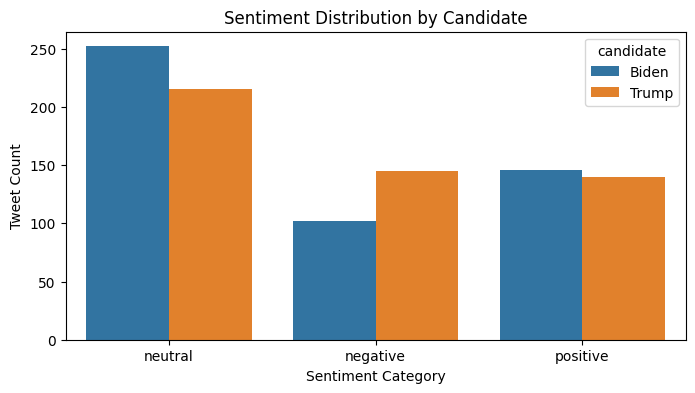

In [16]:
# Visualize Sentiment by Candidate
import seaborn as sns
import matplotlib.pyplot as plt

if 'tweets' in locals() and not tweets.empty and 'sentiment_category' in tweets.columns:
    plt.figure(figsize=(8,4))
    # Use 'sentiment_category' for the x-axis
    sns.countplot(data=tweets, x='sentiment_category', hue='candidate')
    plt.title('Sentiment Distribution by Candidate')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Tweet Count')
    plt.show()
else:
    print("The 'tweets' DataFrame is not available or does not have a 'sentiment_category' column. Cannot plot.")


In [17]:
# Top Hashtags per Candidate
from collections import Counter

def extract_hashtags(text):
    return re.findall(r'#\w+', str(text).lower())

tweets['hashtags'] = tweets['tweet'].apply(extract_hashtags)

for candidate in ['Biden', 'Trump']:
    c_hashtags = sum(tweets[tweets['candidate']==candidate]['hashtags'], [])
    top_tags = Counter(c_hashtags).most_common(10)
    print(f"Top 10 hashtags for {candidate}:")
    print(top_tags)


Top 10 hashtags for Biden:
[('#biden', 319), ('#joebiden', 198), ('#trump', 128), ('#election2020', 60), ('#elections2020', 34), ('#kamalaharris', 30), ('#bidenharris2020', 30), ('#donaldtrump', 22), ('#vote', 19), ('#biden2020', 18)]
Top 10 hashtags for Trump:
[('#trump', 442), ('#biden', 84), ('#donaldtrump', 74), ('#election2020', 48), ('#trump2020', 33), ('#elections2020', 32), ('#joebiden', 29), ('#usa', 22), ('#electionday', 21), ('#maga', 16)]


In [19]:
# Interactive Plot with Plotly
# import plotly.express as px # Already imported earlier
import plotly.express as px

# This section was previously for plotting the real-time API data (using 'df')
# We will now add a plot using the 'tweets' DataFrame from the Kaggle data analysis.

# Plotting the distribution of VADER compound sentiment scores for each candidate
if 'tweets' in locals() and not tweets.empty and 'sentiment' in tweets.columns and 'candidate' in tweets.columns:
    fig = px.histogram(
        tweets,
        x='sentiment', # Assuming 'sentiment' column in 'tweets' holds the compound score after analysis
        color='candidate',
        marginal='box', # Add box plot for summary statistics
        nbins=50,       # Number of bins for the histogram
        title="Distribution of Sentiment Scores by Candidate (Kaggle Data)"
    )
    fig.update_layout(xaxis_title="Sentiment Compound Score", yaxis_title="Count")
    fig.show()
else:
     print("Required columns ('sentiment', 'candidate') are missing in 'tweets' DataFrame or 'tweets' is empty. Cannot plot sentiment score distribution.")

In [26]:
# Tweets Example  for Each Sentiment
for candidate in ['Biden', 'Trump']:
    print(f"\nSample Positive Tweets for {candidate}:")
    print(tweets[(tweets['candidate']==candidate) & (tweets['sentiment_category']=='positive')]['tweet'].head(2).values)



Sample Positive Tweets for Biden:
['So happy for all my American friends and followers!\n\n💙🍾🥂🇺🇸\n\n-\n-\n-\n-\n\n#joebiden #kamalaharris #presidentbiden #vicepresidentharris #america #makeamericagreatagain #presidentialdebate https://t.co/jpQ1zaIQqG'
 '@realDonaldTrump When #Biden is in office from next #January;\n\nI HOPE he asks #Obama to the #WhiteHouse a LOT,\n\nJUST TO PISS YOU OFF!🤣']

Sample Positive Tweets for Trump:
['BTW... IM HAVING A #TRUMP PARTY... Been CELEBRATING ALLDAY!!\nSOOO...#TRUMP DON’T WANT TO LEAVE ..THE PEOPLE HOUSE!!  WE KNOW..WHY #TRUMP WANT LEAVE!!!\n\nTick..Tock⏰'
 '@IngrahamAngle @newtgingrich @QuakeMedia Donald Trump has been a failure at everything he’s ever done in his life except for two things:\n\n1. Convincing his ignorant supporters he’s one of them.\n\n2. Getting away with committing crimes.\n\n#VoteOutEveryRepublican \n#TrumpCrimeFamily \n#DonaldTrump \n\nhttps://t.co/VT1pkDc69x']


# Key Findings

The code's analysis provides a snapshot of online sentiment surrounding the two major candidates in the 2020 US Election, highlighting differences in sentiment levels, trends, and associated topics based on the provided Kaggle dataset. The Gradio interface allows for repeating this analysis with new datasets.

* Sentiment Differences Between Candidates:
The analysis likely reveals whether tweets about Joe Biden and Donald Trump had different overall sentiment distributions (more positive, negative, or neutral tweets).
* Average Sentiment Trends Over Time: The line plot of average sentiment over time allows you to observe if there were shifts in the overall sentiment towards each candidate as the election period progressed. This could highlight the impact of specific events or campaign activities.
* Distribution of Sentiment Scores: The histogram of VADER compound scores shows the spread of sentiment scores for each candidate. This can indicate if tweets about one candidate tended to have stronger (more extreme positive or negative) or milder sentiments compared to the other.
Prevalent Sentiment Categories: The count plot of sentiment categories directly shows which sentiment (positive, negative, or neutral) was most common for each candidate's tweets within the sampled dataset.
* Key Topics/Themes: The analysis of top hashtags used for each candidate can provide insight into the most discussed topics or themes associated with them on Twitter during that period.
* Sample Tweet Context: Looking at sample tweets for each sentiment category for each candidate gives a qualitative understanding of why tweets were classified as positive, negative, or neutral.

# Deployment using Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Cleaning function
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower().strip()

# Sentiment function
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Main Gradio function to handle two files
def analyze_candidate_sentiment(biden_csv_file, trump_csv_file):
    all_tweets = pd.DataFrame()
    errors = []

    # Process Biden's file
    if biden_csv_file:
        try:
            df_biden = pd.read_csv(biden_csv_file)
            if 'text' not in df_biden.columns:
                errors.append("Biden's CSV must have a 'text' column!")
            else:
                df_biden['clean_text'] = df_biden['text'].apply(clean_text)
                df_biden['sentiment'] = df_biden['clean_text'].apply(get_sentiment)
                df_biden['candidate'] = 'Biden'
                all_tweets = pd.concat([all_tweets, df_biden], ignore_index=True)
        except Exception as e:
            errors.append(f"Error processing Biden's file: {e}")
    else:
        errors.append("No file uploaded for Biden.")

    # Process Trump's file
    if trump_csv_file:
        try:
            df_trump = pd.read_csv(trump_csv_file)
            if 'text' not in df_trump.columns:
                 errors.append("Trump's CSV must have a 'text' column!")
            else:
                df_trump['clean_text'] = df_trump['text'].apply(clean_text)
                df_trump['sentiment'] = df_trump['clean_text'].apply(get_sentiment)
                df_trump['candidate'] = 'Trump'
                all_tweets = pd.concat([all_tweets, df_trump], ignore_index=True)
        except Exception as e:
             errors.append(f"Error processing Trump's file: {e}")
    else:
        errors.append("No file uploaded for Trump.")

    if all_tweets.empty:
        return "Could not process any files. Errors:\n" + "\n".join(errors)

    out = ""
    if errors:
        out += "## Warnings/Errors:\n" + "\n".join(errors) + "\n\n"

    # Analyze combined data
    out += "## Overall Sentiment Counts\n"
    overall_summary = all_tweets['sentiment'].value_counts().to_frame('count').reset_index().rename(columns={'index': 'sentiment'})
    out += overall_summary.to_markdown(index=False)
    out += "\n\n"

    # Analyze sentiment by candidate
    out += "## Sentiment Counts by Candidate\n"
    sentiment_by_candidate = all_tweets.groupby('candidate')['sentiment'].value_counts().unstack(fill_value=0)
    out += sentiment_by_candidate.to_markdown()
    out += "\n\n"

    # Example tweets for each candidate and sentiment
    out += "## Sample Tweets by Candidate and Sentiment\n"
    for candidate in all_tweets['candidate'].unique():
        out += f"### {candidate}\n"
        for sent in ['positive', 'negative', 'neutral']:
            examples = all_tweets[(all_tweets['candidate']==candidate) & (all_tweets['sentiment']==sent)]['text'].head(2).tolist()
            out += f"**{sent.capitalize()} Examples:**\n"
            if examples:
                out += '\n'.join(f"- {tweet}" for tweet in examples) + '\n\n'
            else:
                out += "*(No tweets found for this category)*\n\n"


    return out

# Adjusted Gradio interface for two file inputs
iface = gr.Interface(
    fn=analyze_candidate_sentiment,
    inputs=[
        gr.File(label="Upload Biden's Twitter CSV (with 'text' column)"),
        gr.File(label="Upload Trump's Twitter CSV (with 'text' column)")
    ],
    outputs="markdown",
    title="VibeScope: Election Twitter Sentiment Analyzer (Two Candidates)",
    description="Upload the Twitter dataset CSV files for each candidate to analyze the sentiment using NLP."
)

iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c4088a3cc5cdea961d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
